In [1]:
import os
import hydra
import logging
import json
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from sklearn.metrics import f1_score
from scipy.optimize import minimize

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.metrics import macro_f1_from_proba
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.experiment.optimization import find_optimal_threshold_for_label, decode_label
from src.experiment.model.custom_metrics import lgb_macro_auc, lgb_macro_f1

In [2]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=077-ensemble_v2").split(",")

In [3]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with initialize(version_base=None, config_path="../configs"):
    CFG = compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(CFG)  # use HydraConfig for notebook to use hydra job

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.StreamHandler()
    logger.addHandler(handler)


warnings.filterwarnings("ignore")
INPUT_DIR = Path(CFG.paths.input_dir)
OUTPUT_DIR = Path(CFG.paths.output_dir)
BASE_OUTPUT_DIR = Path(CFG.paths.resource_dir) / "outputs"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

### Load Data


In [4]:
def assign_meta(df: pd.DataFrame, data="train"):
    df["data"] = data
    df["fold"] = -1
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = pd.read_csv(INPUT_DIR / "test.csv").rename(columns={"Unnamed: 0": "uid"})
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(train_df, data="train")
test_df = assign_meta(test_df, data="test")
raw_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

### Ensemble


In [5]:
def get_pred_df(ensemble_exps):
    train_pred_df = pd.DataFrame()
    test_pred_df = pd.DataFrame()
    for exp in ensemble_exps:
        logger.info(f"Load {exp} ...")
        train_filepath = BASE_OUTPUT_DIR / exp / "valid_result_df.pkl"
        test_filepath = BASE_OUTPUT_DIR / exp / "test_result_df.pkl"

        train_result_df = joblib.load(train_filepath).set_index("uid")
        test_result_df = joblib.load(test_filepath)

        test_pred_df_ = test_result_df[["uid", 0, 1, 2]].groupby("uid").mean()
        test_pred_df_["pred"] = test_pred_df_.to_numpy().tolist()

        train_pred_df = pd.concat([train_pred_df, train_result_df[["pred"]].add_prefix(f"{exp}_")], axis=1)
        test_pred_df = pd.concat([test_pred_df, test_pred_df_[["pred"]].add_prefix(f"{exp}_")], axis=1)

    return train_pred_df.reset_index(), test_pred_df.reset_index()


train_pred_df, test_pred_df = get_pred_df(CFG.ensemble_exps)
train_pred_df = pd.merge(train_df[["uid", "health"]], train_pred_df, on="uid")
pred_cols = [col for col in train_pred_df.columns if col.endswith("pred")]

Load experiment=043-tabular_v3 ...
Load experiment=049-tabular_v3 ...
Load experiment=048-tabular_v3 ...
Load experiment=031-tabular_v2 ...
Load experiment=032-tabular_v3 ...
Load experiment=042-tabular_v2 ...
Load experiment=061-stacking_v3 ...


In [6]:
def macro_f1_score(weights, preds, true_labels):
    weighted_preds = np.average(preds, axis=1, weights=weights)
    labels_pred = np.argmax(weighted_preds, axis=1)
    return -f1_score(true_labels, labels_pred, average="macro")  # 最大化のために負にする


def optimize_weights(preds, true_labels):
    num_predictors = preds.shape[1]  # 予測器の数
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    initial_weights = np.full(num_predictors, 1 / num_predictors)
    bounds = [(0, 1) for _ in range(num_predictors)]
    result = minimize(
        macro_f1_score,
        initial_weights,
        args=(preds, true_labels),
        method="SLSQP",
        bounds=bounds,
        constraints=cons,
    )

    return result.x if result.success else None


def opt_decode_preds(preds, label):
    opt_results, val_pred_label = find_optimal_threshold_for_label(
        proba_matrix=preds,
        true_labels=label,
        label_indices=[2, 0, 1],
    )

    best_f1_score = f1_score(
        y_true=label,
        y_pred=val_pred_label,
        average="macro",
    )
    return best_f1_score, opt_results

In [7]:
preds = np.array(train_pred_df[pred_cols].to_numpy().tolist())
label = train_pred_df["health"].to_numpy()

weights = CFG.get("ensemble_weights")
if weights is None:
    weights = optimize_weights(preds, label)

assert len(weights) == preds.shape[1]

weighted_preds = np.average(preds, axis=1, weights=weights)

best_f1_score, opt_results = opt_decode_preds(weighted_preds, label)
logger.info(f"weights: {weights}")
logger.info(f"Best F1 Score: {best_f1_score}")
train_pred_df["pred_label"] = decode_label(proba_matrix=weighted_preds, thresholds=opt_results)
score = f1_score(y_pred=train_pred_df["pred_label"], y_true=label, average="macro")
logger.info(f"Macro F1 Score: {score}")

test_preds = np.array(test_pred_df[pred_cols].to_numpy().tolist())
test_pred_df["pred"] = np.average(test_preds, axis=1, weights=weights).tolist()
test_pred_df["pred_label"] = decode_label(
    proba_matrix=np.array(test_pred_df["pred"].to_numpy().tolist()),
    thresholds=opt_results,
)

result_dict = {"weights": list(weights), "opt_results": opt_results, "best_f1_score": best_f1_score}
json.dump(result_dict, open(OUTPUT_DIR / "result.json", "w"), indent=4)

weights: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
Best F1 Score: 0.3726492561406023
Macro F1 Score: 0.3726492561406023


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaV

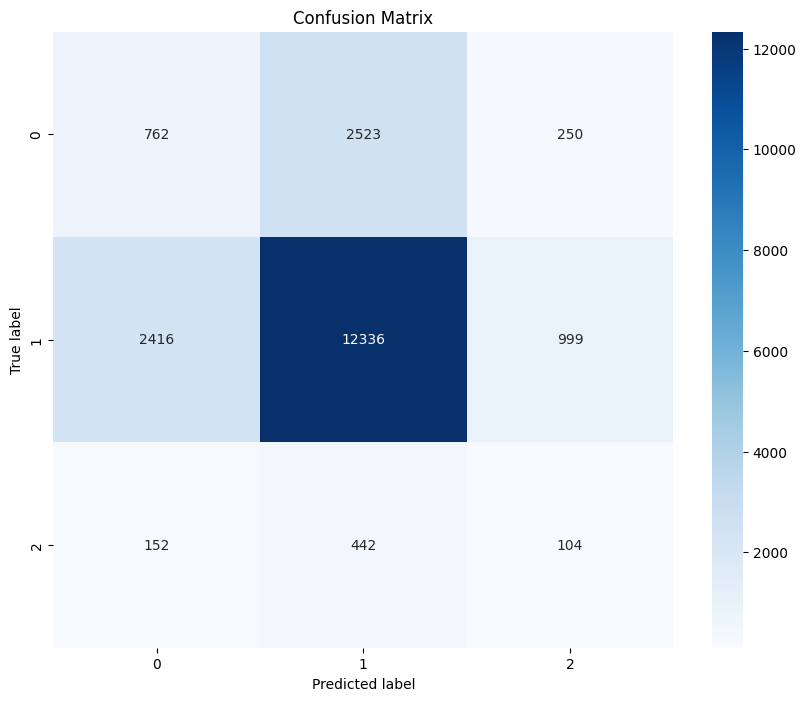

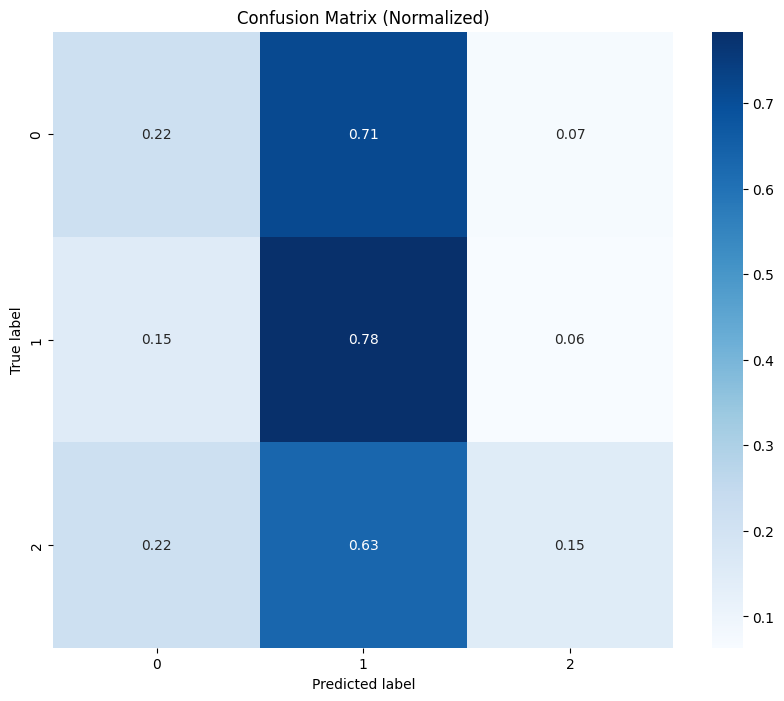

In [8]:
fig = plot_confusion_matrix(y_true=train_pred_df["health"], y_pred=train_pred_df["pred_label"])
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(y_true=train_pred_df["health"], y_pred=train_pred_df["pred_label"], normalize=True)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [9]:
submission_df = test_pred_df[["uid", "pred_label"]].sort_values("uid")
submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}_{score:.3f}.csv"
submission_df.to_csv(submission_filepath, index=False, header=False)

In [10]:
submission_df

,uid,pred_label
0,19984,1
1,19985,1
2,19986,1
3,19987,1
4,19988,1
...,...,...
19697,39964,1
19698,39965,1
19699,39966,2
19700,39967,1
